In [1]:
# Import packages
# DL Packages
import tensorflow as tf
import keras

# Others
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sympy as sym
import seaborn as sns

from sklearn.metrics import confusion_matrix

2023-11-29 13:42:51.561847: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:42:51.584741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 13:42:51.584763: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 13:42:51.584774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 13:42:51.588668: I tensorflow/core/platform/cpu_feature_g

# Examine the Data:

Begin by again looking at the shapes

In [2]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
print("Xtrain shape: ", Xtrain.shape)
print("Xtrain min, max: ", Xtrain.min(), Xtrain.max())
print("-----------------------")
print("Ytrain sthape: ", Ytrain.shape)
print("Ytrain classes: ", np.unique(Ytrain))
print("-----------------------")
print("Xtest.shape: ", Xtest.shape)
print("Xtest min, max: ", Xtrain.min(), Xtrain.max())
print("-----------------------")
print("Ytest shape: ", Ytest.shape)
print("Ytest classes: ", np.unique(Ytrain))

Xtrain shape:  (60000, 28, 28)
Xtrain min, max:  0 255
-----------------------
Ytrain sthape:  (60000,)
Ytrain classes:  [0 1 2 3 4 5 6 7 8 9]
-----------------------
Xtest.shape:  (10000, 28, 28)
Xtest min, max:  0 255
-----------------------
Ytest shape:  (10000,)
Ytest classes:  [0 1 2 3 4 5 6 7 8 9]


Same exact shapes and sizes and number of classes as the first problem. This means we're expecting 28x28 grayscale images, but suppodely this one is "fashion" so let's see why.

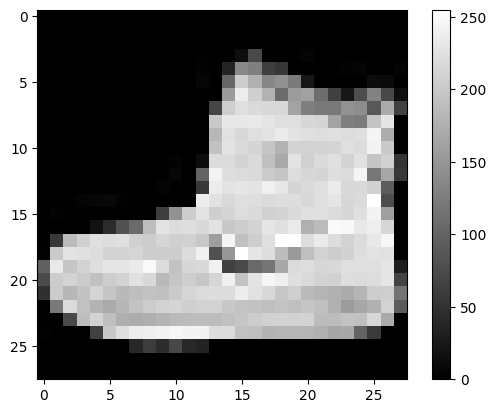

In [4]:
plt.imshow(Xtrain[0], cmap="gray")
plt.colorbar();

It's a boot! Let's look at the all the classes like last time. I got the mappings from labels to classes from [here](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

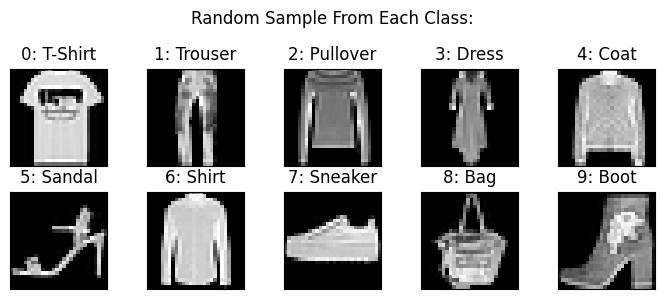

In [5]:
ncols = 5
nrows = 2
label_vals = np.unique(Ytrain)
# By label val index
mnist_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
f, ax = plt.subplots(nrows=nrows, ncols=ncols)
f.set_size_inches(7,3)
plt.suptitle("Random Sample From Each Class:")
for i in range(nrows):
    for j in range(ncols):
        n = label_vals[i*ncols + j]
        is_n = np.nonzero(Ytrain==n)[0]
        random_i = np.random.choice(is_n)
        ax[i,j].imshow(Xtrain[random_i], origin="upper", cmap="gray")
        ax[i,j].set_aspect(1)
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].set_title(f"{n}: {mnist_labels[n]}")
plt.tight_layout()

# Pre-Process Data:

First we will normalize the data to be between 0-1. NO flattening this time, but we'll add an extra dimension to make it (28,28,1). We will use one hot encoding to represent the data labels.

In [6]:
Xtrain_norm = np.expand_dims(Xtrain.astype(float)/np.max(Xtrain),-1)
Xtest_norm = np.expand_dims(Xtest.astype(float)/np.max(Xtest),-1)
def OHE(labels):

    Y = np.zeros((labels.size, 1), dtype=int)
    unique_vals = np.unique(labels)
    label_map = {}
    for i, val in enumerate(unique_vals):
        label_map[val] = i
    count = 0
    for i, label in enumerate(labels):
        # Assign label
        Y[i] = label_map[label]

    Y_OHE = np.zeros((Y.shape[0], len(label_map)), dtype=int)
    for i in range(Y.shape[0]):
        Y_OHE[i, Y[i]] = 1
    Y = Y_OHE

    return Y_OHE

Ytrain_OHE = OHE(Ytrain)
Ytest_OHE = OHE(Ytest)

To verify everything worked, look at the first sample:

Ytrain[0]: 9, Boot  Ytrain_OHE[0]: [0 0 0 0 0 0 0 0 0 1]


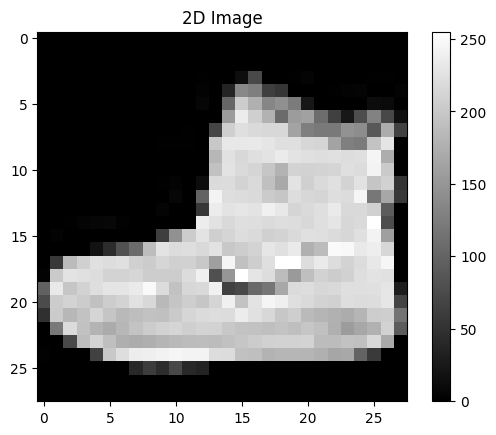

In [7]:
print("Ytrain[0]:", f"{Ytrain[0]},", mnist_labels[Ytrain[0]], " Ytrain_OHE[0]:", Ytrain_OHE[0])
plt.imshow(Xtrain[0], cmap="gray")
plt.title("2D Image")
plt.colorbar();

Looks good again!

# Make/Train a Network:

In [8]:
input_size = (28, 28, 1)
output_size = 10 # one hot encoded label vals
model = keras.models.Sequential([
    keras.Input(shape=input_size),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=4, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(output_size, activation="softmax")
], name="mnist_dense")
model.build(input_size)
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "mnist_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 4)           292       
                                                                 
 flatten (Flatten)           (None, 196)               

2023-11-29 13:42:53.796485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 13:42:53.799381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 13:42:53.799469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
history = model.fit(Xtrain_norm, Ytrain_OHE, batch_size=1000, epochs=100, validation_data=(Xtest_norm, Ytest_OHE))

Epoch 1/100


2023-11-29 13:42:54.499413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-29 13:42:54.675356: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-29 13:42:54.944546: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-29 13:42:55.214051: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb5415f5410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 13:42:55.214084: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2023-11-29 13:42:55.217002: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 13:42:55.260967: I ./tensorflow/compiler/jit/device_compiler.h:

60/60 [==============================] - 3s 6ms/step - loss: 1.8019 - categorical_accuracy: 0.3637 - val_loss: 0.9490 - val_categorical_accuracy: 0.6536
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.8715 - categorical_accuracy: 0.6796 - val_loss: 0.7035 - val_categorical_accuracy: 0.7526
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6941 - categorical_accuracy: 0.7489 - val_loss: 0.6097 - val_categorical_accuracy: 0.7797
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6075 - categorical_accuracy: 0.7814 - val_loss: 0.5505 - val_categorical_accuracy: 0.7995
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5483 - categorical_accuracy: 0.8020 - val_loss: 0.5077 - val_categorical_accuracy: 0.8143
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5094 - categorical_accuracy: 0.8143 - val_loss: 0.4769 - val_categorical_accuracy: 0.8262
Epoch 7/100
60/60 [===

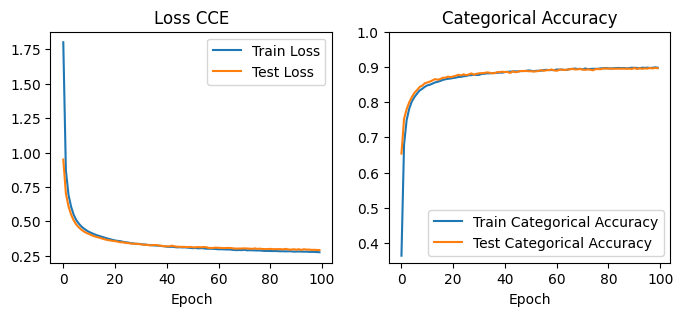

In [10]:
history.history.keys()
f, ax = plt.subplots(ncols=2)
f.set_size_inches(8,3)
ax[0].plot(history.history["loss"], label="Train Loss")
ax[0].set_title("Loss CCE")
ax[0].plot(history.history["val_loss"], label="Test Loss")
# ax[0].set_yscale("log")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(history.history["categorical_accuracy"], label="Train Categorical Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Categorical Accuracy")
ax[1].plot(history.history["val_categorical_accuracy"], label="Test Categorical Accuracy")
ax[1].set_ylim(min(history.history["categorical_accuracy"])-0.02, 1)
ax[1].legend();

In [11]:

def plot_confusion_matrix(Y: np.array, pred: np.array, labels=[], savename="", logscale=False):
    """
    Convenience function for generating a confusion Matrix

    Args:
        Y (np.array): Actual labels for the dataset (n rows, 1 column)
        pred (np.array): Predicted labels for the data (n rows, 1 column)
        labels (list of str): class labels
        savename (str, optional): File to save plot to. If none is given shows figure.
                                    Defaults to "".

    Returns:
        confusion matrix
    """
    # Figure out predicted class -- infer from Y and pred the number of classes
    if Y.shape[1] > 1:
        Y_labels = np.zeros(Y.shape[0], dtype=int)
        pred_labels = np.zeros_like(Y_labels)
        for i in range(Y.shape[0]):
            Y_labels[i] = np.argmax(Y[i])
            pred_labels[i] = np.argmax(pred[i])
    else:
        Y_labels = Y
        pred_labels = (Y >= 0.5).astype(int)
    cm = confusion_matrix(Y_labels, pred_labels)
    f, ax = plt.subplots()
    if logscale:
        from matplotlib.colors import LogNorm, Normalize
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', norm=LogNorm())
    else:
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    # labels, title and ticks
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    if not labels:
        labels = np.arange(max(Y.shape[1], 2))
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    if savename != "":
        plt.savefig(savename)
        plt.close(f)
    else:
        f.set_size_inches((8,8))
        plt.tight_layout()
        plt.show()
        
    return cm

313/313 [==============================] - 0s 779us/step


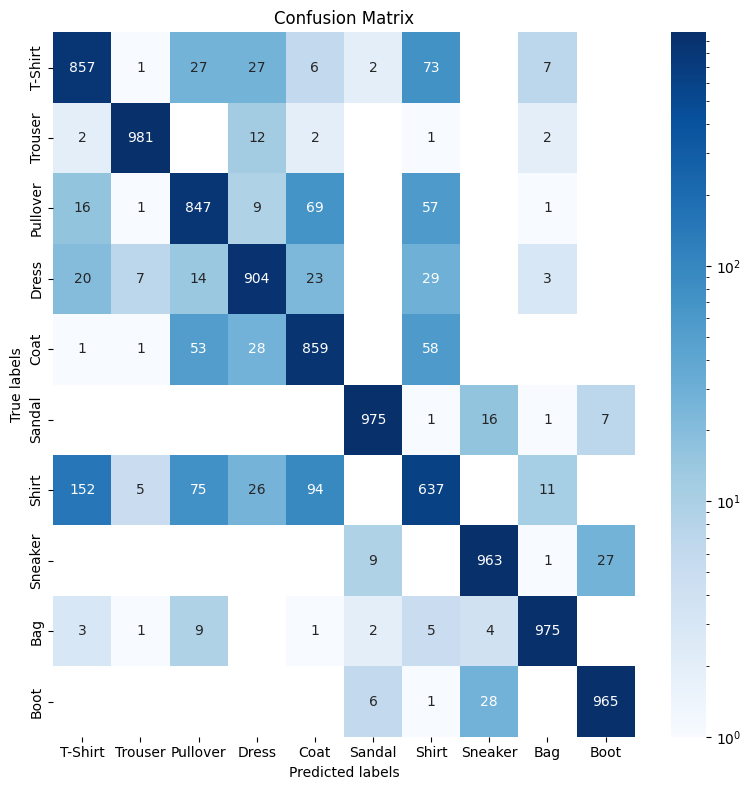

array([[857,   1,  27,  27,   6,   2,  73,   0,   7,   0],
       [  2, 981,   0,  12,   2,   0,   1,   0,   2,   0],
       [ 16,   1, 847,   9,  69,   0,  57,   0,   1,   0],
       [ 20,   7,  14, 904,  23,   0,  29,   0,   3,   0],
       [  1,   1,  53,  28, 859,   0,  58,   0,   0,   0],
       [  0,   0,   0,   0,   0, 975,   1,  16,   1,   7],
       [152,   5,  75,  26,  94,   0, 637,   0,  11,   0],
       [  0,   0,   0,   0,   0,   9,   0, 963,   1,  27],
       [  3,   1,   9,   0,   1,   2,   5,   4, 975,   0],
       [  0,   0,   0,   0,   0,   6,   1,  28,   0, 965]])

In [12]:
Ypred = model.predict(Xtest_norm)
plot_confusion_matrix(Ytest_OHE, Ypred, labels=mnist_labels, logscale=True)

The cases it gets wrong makes sense, as most of the confusion is between shirts and shirt-like objects. Pants are predicted well, and the little confusion with footware is between different types of footware.